# Setup

## Create API Key

Go create an API key for using Gemini (FREE!) here, https://aistudio.google.com/app/apikey. Make sure the plan says "Free of charge"

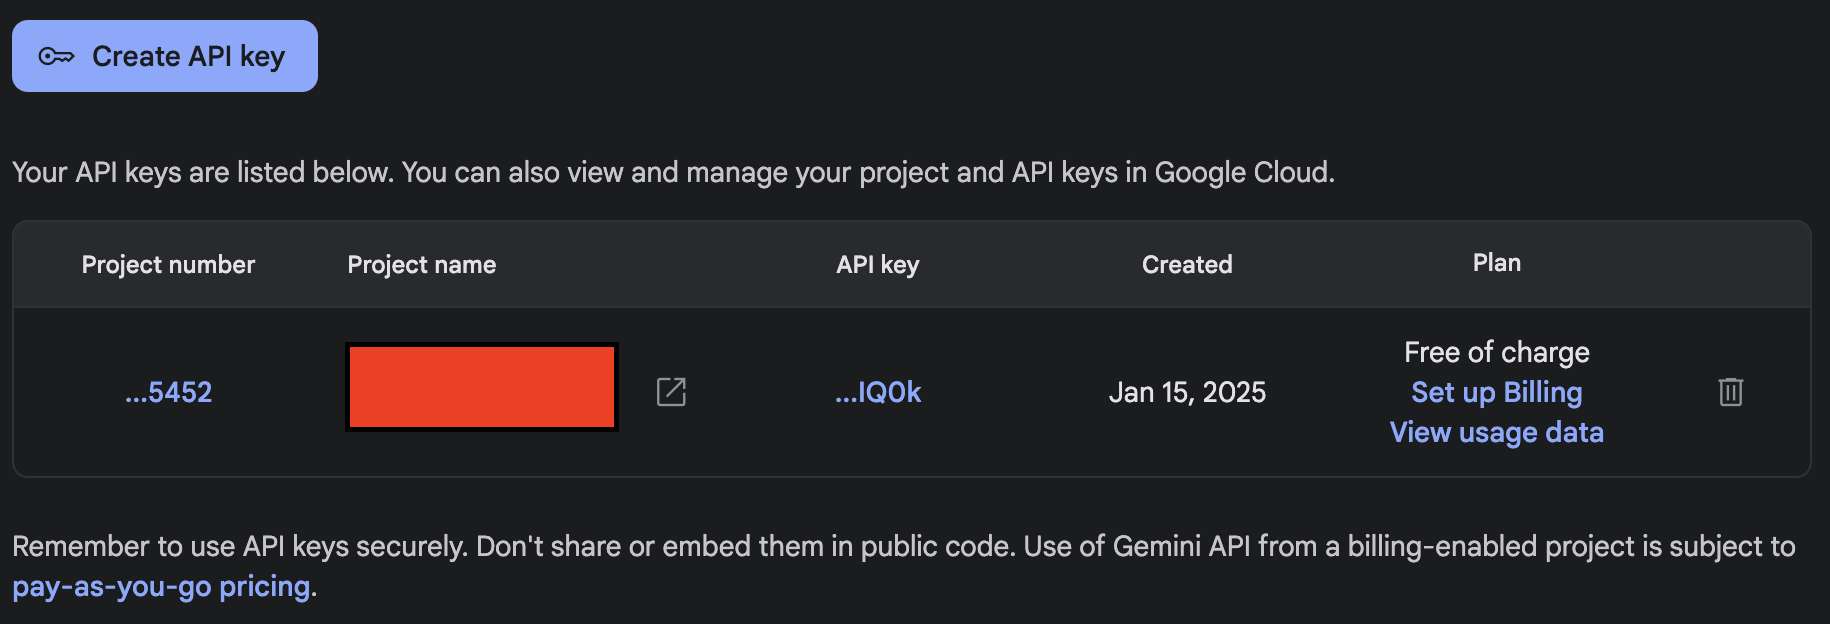

## Add API to notebook

After creating your API key, add it to your colab notebook.

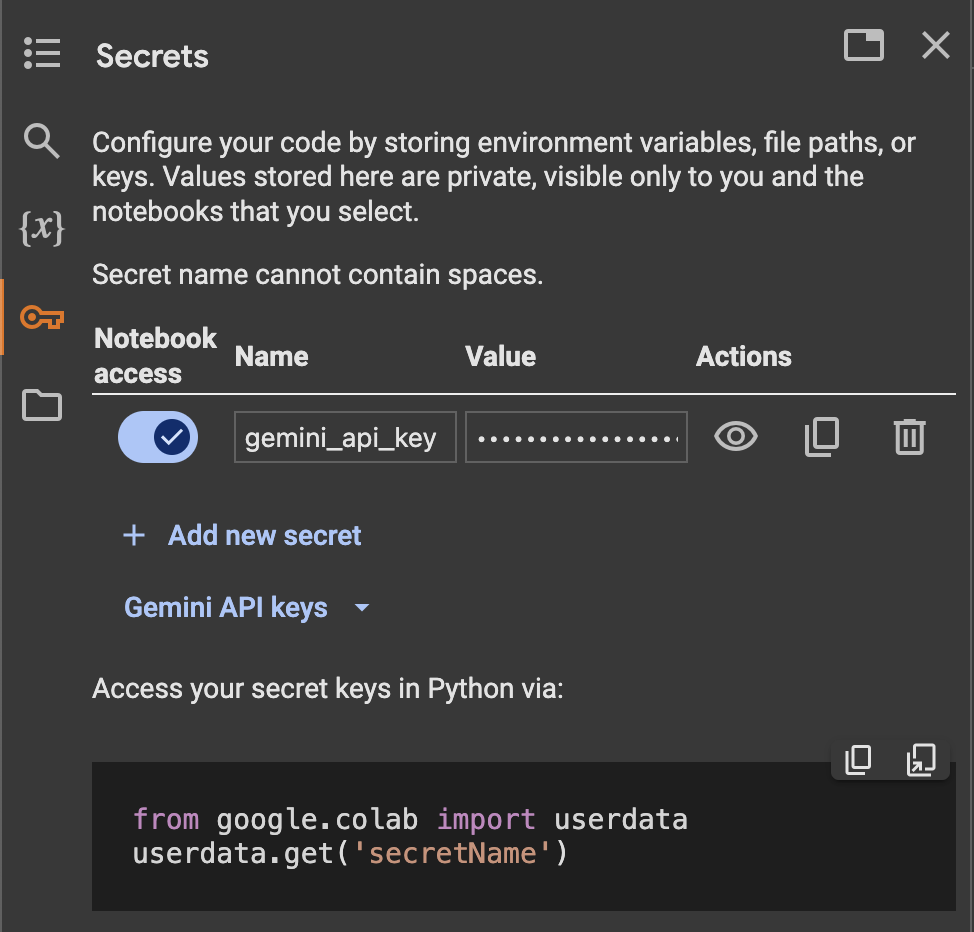

## Download necessary files/libs

In [ ]:
!wget https://github.com/neubig/anlp-code/raw/refs/heads/main/data/sst-sentiment-text-threeclass/dev.txt

--2025-01-25 10:03:58--  https://github.com/neubig/anlp-code/raw/refs/heads/main/data/sst-sentiment-text-threeclass/dev.txt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/neubig/anlp-code/refs/heads/main/data/sst-sentiment-text-threeclass/dev.txt [following]
--2025-01-25 10:03:58--  https://raw.githubusercontent.com/neubig/anlp-code/refs/heads/main/data/sst-sentiment-text-threeclass/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122071 (119K) [text/plain]
Saving to: ‘dev.txt’

dev.txt             100%[===================>] 119.21K  --.-KB/s    in 0.02s   

2025-01-25 10:03:59 (6.61 MB/

# Code

## FYI: For the free tier, you are allowed 15 requests per minute.

In [ ]:
from google.colab import userdata
api_key = userdata.get('gemini_api_key')

In [ ]:
import google.generativeai as genai
from ratelimit import limits, sleep_and_retry
from tqdm import tqdm
from sklearn.metrics import accuracy_score

genai.configure(api_key=api_key)
generation_config = genai.GenerationConfig(
        temperature=0,
)
model = genai.GenerativeModel("gemini-2.0-flash-001", generation_config=generation_config)

In [ ]:
from google.api_core import retry

# Catch transient Gemini errors.
def is_retryable(e) -> bool:
    if retry.if_transient_error(e):
        # Good practice, but probably won't fire with the google-genai SDK
        return True
    elif (isinstance(e, genai.errors.ClientError) and e.code == 429):
        # Catch 429 quota exceeded errors
        return True
    elif (isinstance(e, genai.errors.ServerError) and e.code == 503):
        # Catch 503 model overloaded errors
        return True
    else:
        return False

@retry.Retry(predicate=is_retryable)
def generate_content_with_rate_limit(prompt):
  return model.generate_content(prompt).text

## Sentiment analysis



For sentiment analysis, we will be using the following prompt:

```
Analyse the sentiment of the following text: ```text```
if the sentiment is positive output '1', '0' for neutral, and '-1' for negative.
**DO NOT OFFER ANY EXPLANATION JUST OUTPUT THE NUMBER**
```
LLMs nowaday usually have chain-of-thought baked in so they usually will output their reasoning before answering.
It is important to tell the model not to output their explanation; otherwise, it will not be easy to programmatically use the outputs.
Alternatively, you can use structured outputs for ease of parsing.

In [ ]:
def read_xy_data(filename: str) -> tuple[list[str], list[int]]:
    x_data = []
    y_data = []
    with open(filename, 'r') as f:
        for line in f:
            label, text = line.strip().split(' ||| ')
            x_data.append(text)
            y_data.append(int(label))
    return x_data, y_data

In [ ]:
x_test, y_test = read_xy_data('dev.txt')
x_test, y_test = x_test[:100], y_test[:100]

In [ ]:
prompt = f"Analyse the sentiment of the following text: ```{x_test[0]}``` if the sentiment is positive output '1', '0' for neutral, and '-1' for negative. **DO NOT OFFER ANY EXPLANATION JUST OUTPUT THE NUMBER**"
generate_content_with_rate_limit(prompt).strip()

In [ ]:
# output = []
# for sent in tqdm(x_test):
#   prompt = f"Analyse the sentiment of the following text: ```{sent}``` if the sentiment is positive output '1', '0' for neutral, and '-1' for negative. **DO NOT OFFER ANY EXPLANATION JUST OUTPUT THE NUMBER**"
#   try:
#     output.append(int(generate_content_with_rate_limit(prompt).strip()))
#   except:
#     output.append(0)

100%|██████████| 100/100 [06:12<00:00,  3.72s/it]


In [ ]:
# accuracy_score(y_test, output)

0.8

## Question Answering



For QA, we will use a straightforward prompt commonly used for this task

```
Answer the question based on the context below. If the
question cannot be answered using the information provided, answer
with "I don't know".

Context: {context}

Question: {question}

Answer:
```

In [ ]:
prompt = """Answer the question based on the context below. If the
question cannot be answered using the information provided, answer
with "I don't know".

Context: Large Language Models (LLMs) are the latest models used in NLP.
Their superior performance over smaller models has made them incredibly
useful for developers building NLP enabled applications. These models
can be accessed via Hugging Face's `transformers` library, via OpenAI
using the `openai` library, and via Cohere using the `cohere` library.

Question: Which libraries and model providers offer LLMs?

Answer: """

In [ ]:
generate_content_with_rate_limit(prompt)

"Hugging Face's `transformers` library, OpenAI's `openai` library, and Cohere's `cohere` library offer LLMs.\n"

### Structured Output

In [ ]:
prompt = """Answer the question based on the context below with a json string with keys "name" and "library_name". If the
question cannot be answered using the information provided, output an empty json.

Context: Large Language Models (LLMs) are the latest models used in NLP.
Their superior performance over smaller models has made them incredibly
useful for developers building NLP enabled applications. These models
can be accessed via Hugging Face's `transformers` library, via OpenAI
using the `openai` library, and via Cohere using the `cohere` library.

Question: Which libraries and model providers offer LLMs?

Answer: """

In [ ]:
generate_content_with_rate_limit(prompt)

'```json\n{"name": ["Hugging Face", "OpenAI", "Cohere"], "library_name": ["transformers", "openai", "cohere"]}\n```\n'

## Few-shot Prompting

Since this is an open-ended generation, we do not want the generation to be boring so temperature is set to 1 instead of 0.

In [ ]:
generation_config = genai.GenerationConfig(
        temperature=1,
)
model = genai.GenerativeModel("gemini-1.5-flash", generation_config=generation_config)

In [ ]:
prompt = """The following is a conversation with an AI assistant.
The assistant is typically sarcastic and witty, producing creative
and funny responses to the users questions. Here are some examples:

User: What is the meaning of life?
AI: """

In [ ]:
print(generate_content_with_rate_limit(prompt))

AI: 42.  Now, if you'll excuse me, I have a universe to save.  Or maybe just a really good nap.  One of the two.



In [ ]:
prompt = """The following are exerpts from conversations with an AI
assistant. The assistant is typically sarcastic and witty, producing
creative  and funny responses to the users questions. Here are some
examples:

User: How are you?
AI: I can't complain but sometimes I still do.

User: What time is it?
AI: It's time to get a watch.

User: What is the meaning of life?
AI: """

In [ ]:
print(generate_content_with_rate_limit(prompt))

AI: 42.  Just kidding...mostly.  The real answer is probably something incredibly mundane, like finding a really good parking spot.  Or maybe achieving optimal laundry-folding efficiency.  Don't hold your breath.



## Chain of Thought prompting

In [ ]:
question = """The great dragon, Perg, sat high atop mount Farbo, breathing fire upon anything within a distance of 1000 feet. Polly could throw the gold javelin, the only known weapon that could sleigh the dragon, for a distance of 400 feet, well within the reach of the dragon's flames. But when Polly held the sapphire gemstone, she could throw the javelin three times farther than when not holding the gemstone. If holding the gemstone, how far outside of the reach of the dragon's flames could Polly stand and still hit the dragon with the gold javelin?
""" #from gsm8k test set
no_cot = "Only output answer, do not offer any explanation"
zero_shot_cot = "Think step-by-step."

1.) No chain-of-thought

In [ ]:
response = generate_content_with_rate_limit(question+no_cot)
print(response)

800 feet



2.) Baked-in chain-of-thought (as-is model is usually trained with CoT data, so we do not need to specify CoT in prompt)

In [ ]:
response = generate_content_with_rate_limit(question)
print(response)

Here's how to solve this problem step-by-step:

1. **Gemstone effect:** With the gemstone, Polly can throw the javelin three times farther than without it.  So, her throw distance becomes 400 feet * 3 = 1200 feet.

2. **Maximum safe distance:** The dragon's flames reach 1000 feet.  Polly can throw the javelin 1200 feet.  Therefore, she can stand 1200 feet - 1000 feet = 200 feet outside the dragon's range and still hit it.

**Answer:** Polly could stand 200 feet outside the reach of the dragon's flames and still hit the dragon.



3.) Explicitly specifiy chain-of-thought

In [ ]:
response = generate_content_with_rate_limit(question+zero_shot_cot)
print(response)

Here's how to solve this problem step-by-step:

1. **Gemstone effect:** With the gemstone, Polly can throw the javelin three times farther than without it.  Three times 400 feet is 3 * 400 feet = 1200 feet.

2. **Maximum throw distance:**  Polly can throw the javelin 1200 feet while holding the gemstone.

3. **Dragon's range:** The dragon's fire reaches 1000 feet.

4. **Safe distance:** To be outside the dragon's fire, Polly needs to be at least 1000 feet away from the dragon.

5. **Distance outside dragon's range:** Since Polly can throw 1200 feet and the dragon's range is 1000 feet, she can stand 1200 feet - 1000 feet = 200 feet outside the dragon's reach and still hit the dragon.

**Answer:** Polly could stand 200 feet outside the reach of the dragon's flames and still hit the dragon with the gold javelin.

